In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from collections import defaultdict
from sklearn.model_selection import train_test_split
import pickle
%matplotlib inline

import avocado
from tqdm import tqdm

In [13]:
plasticc_augment_meta = avocado.load("plasticc_augment", metadata_only=True)
print(plasticc_augment_meta.metadata.columns)
plasticc_augment_meta.metadata.shape

Index(['ra', 'decl', 'ddf', 'host_specz', 'host_photoz', 'host_photoz_error',
       'mwebv', 'class', 'true_submodel', 'redshift', 'true_distmod',
       'true_lensdmu', 'true_vpec', 'true_rv', 'true_av', 'true_peakmjd',
       'libid_cadence', 'tflux_u', 'tflux_g', 'tflux_r', 'tflux_i', 'tflux_z',
       'tflux_y', 'galactic', 'augment_brightness', 'reference_object_id'],
      dtype='object')


(595265, 26)

In [8]:
data_path = os.path.join(str(os.getcwd()), '..', 'data', "plasticc", "data", "plasticc_raw")
plasticc_train_meta = pd.read_csv(os.path.join(data_path, "plasticc_train_metadata.csv.gz"))
print(plasticc_train_meta.columns)
plasticc_train_meta.shape

Index(['object_id', 'ra', 'decl', 'ddf_bool', 'hostgal_specz',
       'hostgal_photoz', 'hostgal_photoz_err', 'distmod', 'mwebv', 'target',
       'true_target', 'true_submodel', 'true_z', 'true_distmod',
       'true_lensdmu', 'true_vpec', 'true_rv', 'true_av', 'true_peakmjd',
       'libid_cadence', 'tflux_u', 'tflux_g', 'tflux_r', 'tflux_i', 'tflux_z',
       'tflux_y'],
      dtype='object')


(7848, 26)

In [26]:
plot_labels_short = {
    6: 'Single $\mu$-lens - 6',
    15: 'TDE - 15',
    16: 'Eclip. Binary - 16',
    42: 'SNII - 42',
    52: 'SNIax - 52',
    53: 'Mira - 53',
    62: 'SNIbc - 62',
    64: 'Kilonova - 64',
    65: 'M-dwarf - 65',
    67: 'SNIa-91bg - 67',
    88: 'AGN - 88',
    90: 'SNIa - 90',
    92: 'RR lyrae - 92',
    95: 'SLSN-I - 95',
    99: 'Unknown - 99',
}


def plot_labels_tuple(class_count1, class_count2, label1, label2, labels_names, log_scale=False, show_lines=False, title="Multi-band Time Series count per class"):
    labels_cc1, values_cc1 = zip(*sorted(class_count1.items()))
    labels_cc2, values_cc2 = zip(*sorted(class_count2.items()))
    
#     if log_scale:
#         values_cc1 = np.log(values_cc1)
#         values_cc2 = np.log(values_cc2)
    
    if labels_names is not None:
        labels = [labels_names[x] for x in labels_cc1]
    else:
        labels = labels_cc1
    
    indexes = np.arange(len(labels_cc1))
    width = 0.35 
    
    fig, ax = plt.subplots(figsize=(12, 6))
    
    rects1 = ax.bar(indexes, values_cc1, width)
    rects2 = ax.bar(indexes + width, values_cc2, width)
    
    ax.set_xticks(indexes + width / 2)
#     ax.set_ylim([0, max(np.max(values_cc1), np.max(values_cc2)) + 150])
    ax.set_xticklabels(labels, rotation=60, ha="right", fontsize=14)
    
    ax.set_xlabel("Class", fontsize=15)
    ax.set_ylabel("Count", fontsize=15)
    ax.set_title(title, fontsize=17)
    
    ax.legend((rects1[0], rects2[0]), (label1, label2), fontsize=15)
    
    def autolabel(rects):
        """
        Attach a text label above each bar displaying its height
        """
        for rect in rects:
            height = rect.get_height()
            ax.text(rect.get_x() + rect.get_width()/2., height + 15,
                    '%d' % int(height),
                    ha='center', va='bottom')

    autolabel(rects1)
    autolabel(rects2)
    if log_scale:
        ax.set_yscale('log')
    plt.tight_layout()
    if show_lines:
        ax.axhline(500, color="blue")
        ax.axhline(5000, color="orange")
#     
#     plt.xlabel("class", fontsize=15)
#     plt.ylabel("count", fontsize=15)
#     plt.title(title, fontsize=17)

def get_counts(df_meta, key="ddf", key2="target"):
    wfd = 0
    ddf = 1

    df_meta_ddf = df_meta[df_meta[key] == ddf]
    df_meta_wfd = df_meta[df_meta[key] == wfd]

    class_count_ddf = defaultdict(int)
    for l in df_meta_ddf[key2]:
        class_count_ddf[l] += 1

    class_count_wfd = defaultdict(int)
    for l in df_meta_wfd[key2]:
        class_count_wfd[l] += 1

    return class_count_ddf, class_count_wfd

merged_labels = {
    6: 'Single $\mu$-lens',
    15: 'TDE',
    16: 'Short period VS',
    42: 'SN',
    52: 'SN',
    53: 'Short period VS',
    62: 'SN',
    64: 'SN',
    65: 'M-dwarf',
    67: 'SN',
    88: 'AGN',
    90: 'SN',
    92: 'Short period VS',
    95: 'SN',
    99: 'Unknown',
}

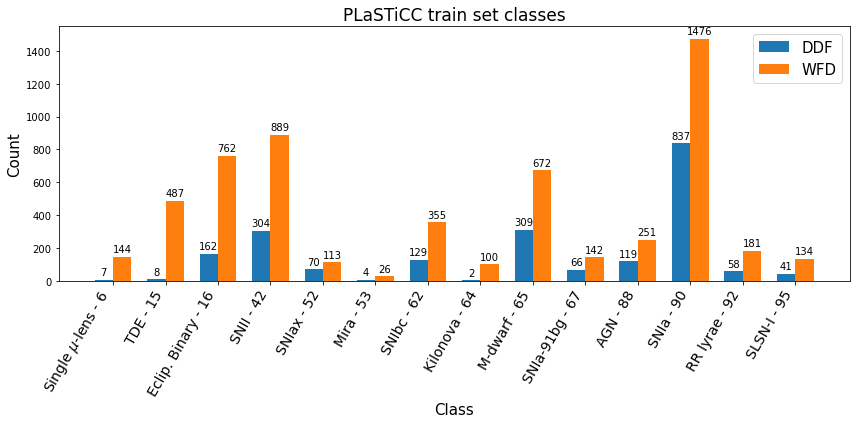

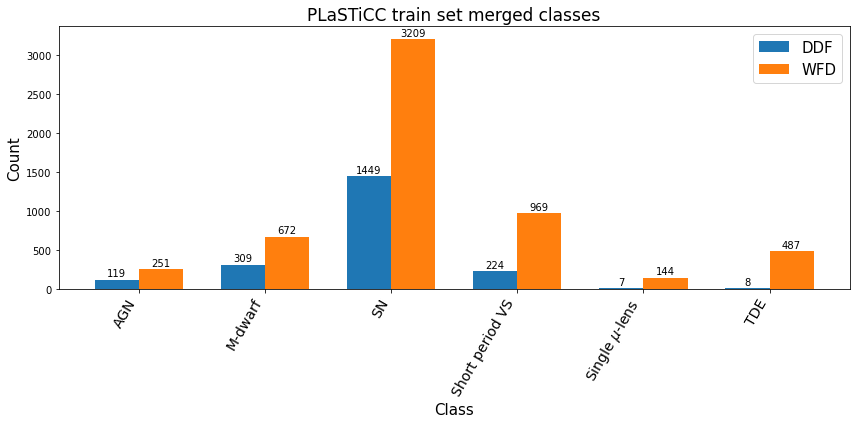

In [72]:
class_count_ddf, class_count_wfd = get_counts(plasticc_train_meta, key="ddf_bool")
plot_labels_tuple(class_count_ddf, class_count_wfd, "DDF", "WFD", plot_labels_short, title="PLaSTiCC train set classes")

class_count_ddf_merged = defaultdict(int)
class_count_wfd_merged = defaultdict(int)
for key, val in class_count_ddf.items():
    class_count_ddf_merged[merged_labels[key]] += val

for key, val in class_count_wfd.items():
    class_count_wfd_merged[merged_labels[key]] += val
    
plot_labels_tuple(class_count_ddf_merged, class_count_wfd_merged, "DDF", "WFD", None, log_scale=False, show_lines=False, title="PLaSTiCC train set merged classes")

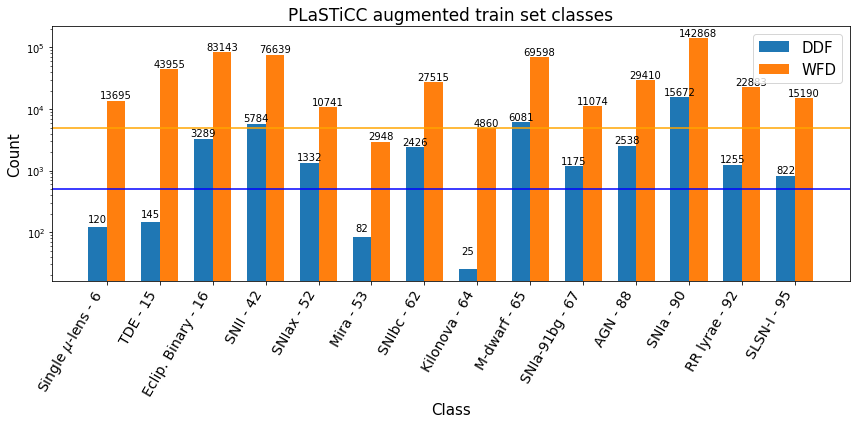

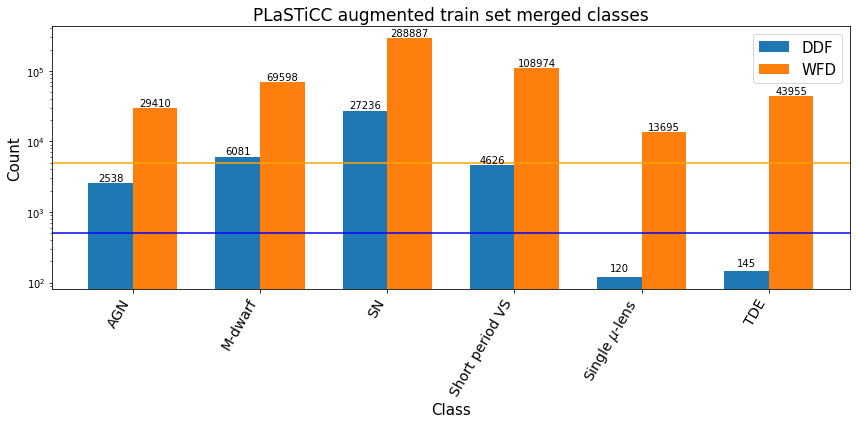

In [73]:
class_count_ddf, class_count_wfd = get_counts(plasticc_augment_meta.metadata, key="ddf", key2="class")
plot_labels_tuple(class_count_ddf, class_count_wfd, "DDF", "WFD", plot_labels_short, log_scale=True, show_lines=True,
                 title="PLaSTiCC augmented train set classes")

class_count_ddf_merged = defaultdict(int)
class_count_wfd_merged = defaultdict(int)
for key, val in class_count_ddf.items():
    class_count_ddf_merged[merged_labels[key]] += val

for key, val in class_count_wfd.items():
    class_count_wfd_merged[merged_labels[key]] += val
    
plot_labels_tuple(class_count_ddf_merged, class_count_wfd_merged, "DDF", "WFD", None, log_scale=True, show_lines=True,
                 title="PLaSTiCC augmented train set merged classes")

### Usage

Although the code augmented all classes in the same proporsion, resulting in an imbalanced augmented dataset, we wont use all the augmented data of every class. More specially, we will downscale the dataset until we get a more balanced dataset.

- For WFD survey: downscale to 5.000 samples on each class (if class has less than 5.000 samples, use all)
- For DDF survey: downscale to 500 samples on each class (if class has less than 500 samples, use all)

WE will also predict on two different classification:
- Real simulated classes (14 in total)
- Merged classes (6 in total: ANG, M-dwarf, SN, Short period VS, single microlens, TDE)


And finaly, for fast test evaluation, we will make a sub-dataset of:
- 500 samples on each class for WFD
- 100 samples on each class for DDF

In [33]:
def plot_labels_single(class_count1, label1, labels_names, log_scale=False, show_lines=False, title="Multi-band Time Series count per class"):
    labels_cc1, values_cc1 = zip(*sorted(class_count1.items()))
    
#     if log_scale:
#         values_cc1 = np.log(values_cc1)
#         values_cc2 = np.log(values_cc2)
    
    if labels_names is not None:
        labels = [labels_names[x] for x in labels_cc1]
    else:
        labels = labels_cc1
    
    indexes = np.arange(len(labels_cc1))
    width = 0.35 
    
    fig, ax = plt.subplots(figsize=(12, 6))
    
    rects1 = ax.bar(indexes, values_cc1, width)
    
    ax.set_xticks(indexes + width / 2)
#     ax.set_ylim([0, max(np.max(values_cc1), np.max(values_cc2)) + 150])
    ax.set_xticklabels(labels, rotation=60, ha="right", fontsize=14)
    
    ax.set_xlabel("Class", fontsize=15)
    ax.set_ylabel("Count", fontsize=15)
    ax.set_title(title, fontsize=17)
    
#     ax.legend((rects1[0]), (label1), fontsize=15)
    
    def autolabel(rects):
        """
        Attach a text label above each bar displaying its height
        """
        for rect in rects:
            height = rect.get_height()
            ax.text(rect.get_x() + rect.get_width()/2., height + 15,
                    '%d' % int(height),
                    ha='center', va='bottom')

    autolabel(rects1)
    if log_scale:
        ax.set_yscale('log')
    plt.tight_layout()
    if show_lines:
        ax.axhline(500, color="blue")
        ax.axhline(5000, color="orange")
#     
#     plt.xlabel("class", fontsize=15)
#     plt.ylabel("count", fontsize=15)
#     plt.title(title, fontsize=17)

def get_counts_single(df_meta, key="ddf", value=1, key2="target"):

    df_meta_ddf = df_meta[df_meta[key] == value]

    class_count_ddf = defaultdict(int)
    for l in df_meta_ddf[key2]:
        class_count_ddf[l] += 1

    return class_count_ddf

Index(['ra', 'decl', 'ddf', 'host_specz', 'host_photoz', 'host_photoz_error',
       'mwebv', 'class', 'true_submodel', 'redshift', 'true_distmod',
       'true_lensdmu', 'true_vpec', 'true_rv', 'true_av', 'true_peakmjd',
       'libid_cadence', 'tflux_u', 'tflux_g', 'tflux_r', 'tflux_i', 'tflux_z',
       'tflux_y', 'galactic', 'augment_brightness', 'reference_object_id'],
      dtype='object')


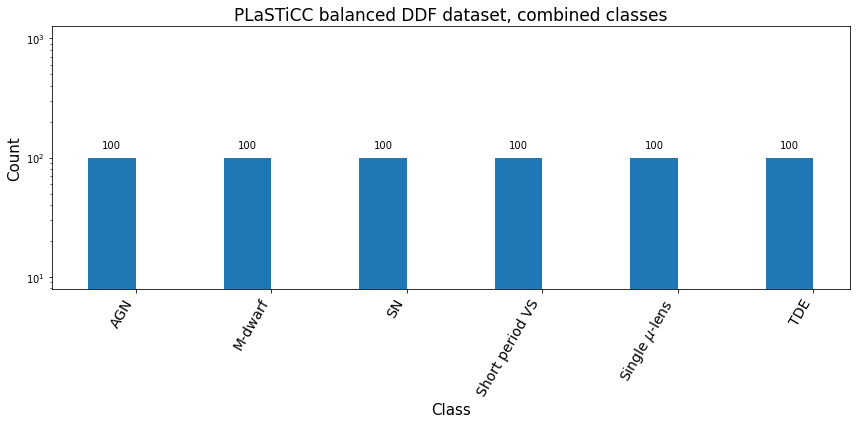

In [38]:
plasticc_augment_meta = avocado.load("plasticc_balanced_combined_classes_small_ddf", metadata_only=True, verify_input_chunks=False)
print(plasticc_augment_meta.metadata.columns)
plasticc_augment_meta.metadata.shape

class_count_ddf = get_counts_single(plasticc_augment_meta.metadata, key="ddf", value=1, key2="class")

class_count_ddf_merged = defaultdict(int)
for key, val in class_count_ddf.items():
    class_count_ddf_merged[merged_labels[key]] += val

plot_labels_single(class_count_ddf_merged, "DDF", None, log_scale=True, show_lines=False,
                 title="PLaSTiCC balanced DDF dataset, combined classes")

Index(['object_id', 'time', 'flux', 'flux_error', 'detected', 'band',
       'reference_time', 'model_flux', 'model_flux_error'],
      dtype='object')


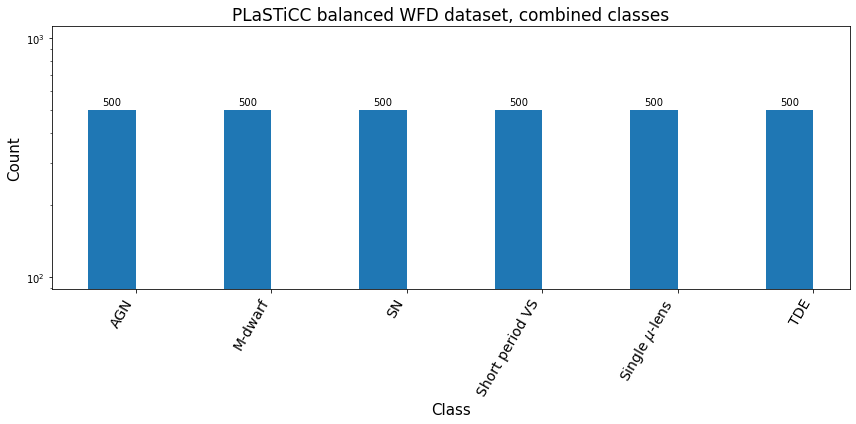

In [43]:
plasticc_augment_meta = avocado.load("plasticc_balanced_combined_classes_small_wfd", metadata_only=False, verify_input_chunks=False)
print(plasticc_augment_meta.objects[0].observations.columns)

class_count_ddf = get_counts_single(plasticc_augment_meta.metadata, key="ddf", value=0, key2="class")

class_count_ddf_merged = defaultdict(int)
for key, val in class_count_ddf.items():
    class_count_ddf_merged[merged_labels[key]] += val

plot_labels_single(class_count_ddf_merged, "WFD", None, log_scale=True, show_lines=False,
                 title="PLaSTiCC balanced WFD dataset, combined classes")

In [80]:
df = plasticc_augment_meta.objects[0].observations
bands = np.unique(df["band"])
# df.plot("time", "flux", fmt=".")
for i in range(len(plasticc_augment_meta.objects)):
    problem = False
    for j, b in enumerate(bands):
        df = plasticc_augment_meta.objects[i].observations
        df = df.sort_values(by=["time"])
        df = df[df["band"] == b]
        t = df["time"].to_numpy()
        diff = t[1:] - t[:-1]
        if any([x <= 0 for x in diff]):
            print("problem on ts", i, "band", j)
            problem = True
            break
            
    if problem:
        print(diff)
        break

problem on ts 1 band 3
[  4.13241482   1.38278076  42.82077566  33.14366483   8.37521387
  30.3434784    1.37862577   6.99575711  38.73766673   2.75932903
 329.91495241  30.43433418  44.15106504   1.38458126   1.41505118
   1.38555075   1.38070326   0.        ]


In [85]:
df = plasticc_augment_meta.objects[1].observations
df = df[df["band"] == bands[3]]
df = df.sort_values(by=["time"])
t = df["time"].to_numpy()
diff = t[1:] - t[:-1]
print(any([x <= 0 for x in diff]))
t

True


array([60140.00156221, 60144.13397703, 60145.51675779, 60188.33753345,
       60221.48119828, 60229.85641216, 60260.19989055, 60261.57851632,
       60268.57427343, 60307.31194016, 60310.07126919, 60639.9862216 ,
       60670.42055579, 60714.57162083, 60715.95620209, 60717.37125327,
       60718.75680402, 60720.13750729, 60720.13750729])

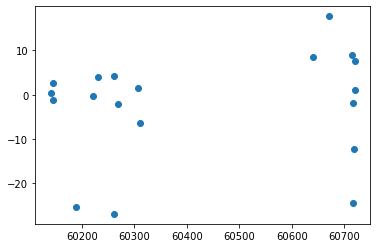

In [88]:
plt.plot(df["time"], df["flux"], 'o')